# Quora Question Pairs

## Description:

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

## Problem Statement

- Identify which questions asked on Quora are duplicates of questions that have already been asked.
- This could be useful to instantly provide answers to questions that have already been answered.
- We are tasked with predicting whether a pair of questions are duplicates or not.

### Source : https://www.kaggle.com/c/quora-question-pairs 

## Real world/Business Objectives and Constraints:

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## Data Overview 

- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

## Performance Metric 
Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s):
1. log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
2. Binary Confusion Matrix

## Import Libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz

import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
warnings.filterwarnings("ignore")
import datetime as dt
from nltk.corpus import stopwords
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from datetime import datetime
from wordcloud import WordCloud
from scipy import sparse
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy import stats
from sklearn.externals import joblib
from prettytable import PrettyTable

**Util Functions**

In [4]:
def save_pickle(filename, matrix):
    with open(filename, 'wb') as outfile:
        pickle.dump(matrix, outfile, pickle.HIGHEST_PROTOCOL)

def load_pickle(filename):
    with open(filename, 'rb') as infile:
        matrix = pickle.load(infile)    
    return matrix

In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
       
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    
    tn, fp, fn, tp = C.ravel()
        
    tpr = tp/(tp+fn)    
    tnr = tn/(tn+fp)
    fpr = fp/(tn+fp)
    fnr = fn/(tp+fn)
    
    print("\nTPR: "+str(round(tpr,3))+", TNR: "+str(round(tnr,3))+", FPR: "+str(round(fpr,3))+", FNR: "+str(round(fnr,3))+"\n")

## Exploratory Data Analysis

In [5]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

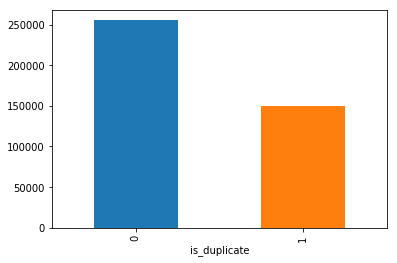

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [12]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3>Checking for NULL values </h3>

In [16]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 and one row in question1

In [17]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [19]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len() 
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

df['word_share'] = df.apply(normalized_word_share, axis=1)
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [20]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [24]:
save_pickle('quora_without_preprocessed.pkl',df)

In [54]:
df = load_pickle('quora_without_preprocessed.pkl')

## Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords (This is not done since in advanced feature stop word count is used)
    - Expanding contractions etc.

In [9]:
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.strip()

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned.strip()

def contractions(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    
    return x

def preprocess(sentence):
    sent = cleanhtml(sentence.strip())
    sent = cleanpunc(sent)
    sent = contractions(sent)
    
    return sent

In [58]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [59]:
start = datetime.now()
df['question1'] = df.apply(lambda row: preprocess(row['question1']), axis=1)
df['question2'] = df.apply(lambda row: preprocess(row['question2']), axis=1)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:06:37.543188


In [60]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [63]:
save_pickle('quora_cleaned.pkl',df)

In [5]:
df = load_pickle('quora_cleaned.pkl')

## Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


**Due to memory constraint let's take random 150K samples**

In [6]:
df = df.sample(150000)
df.shape

(150000, 17)

In [7]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [10]:
start = datetime.now()

if os.path.isfile('nlp_features_train.pkl'):
    df = load_pickle("nlp_features_train.pkl")
    df.fillna('')
else:
    print("Extracting features for train:")
    df = extract_features(df)
    save_pickle("nlp_features_train.pkl",df)

print("Time taken to run this cell :", datetime.now() - start)

Extracting features for train:
token features...
fuzzy features..
Time taken to run this cell : 0:10:18.811450


In [20]:
df = load_pickle('nlp_features_train.pkl')

In [11]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
15754,15754,30071,30072,how do i prepare for a firmware or embedded en...,in companies like google facebook amazon et...,0,1,1,147,129,...,0.192307,1.0,0.0,4.0,24.0,46,47,30,31,0.078125
274358,274358,392988,392989,can lawful permanent residents be denied re en...,if my mother in law residing in casablanca m...,0,1,1,150,198,...,0.162162,0.0,0.0,14.0,30.0,45,43,31,35,0.073333


In [12]:
df = df.drop(['id'], axis=1)
df = df.reset_index(drop=True)
df.head(2)

,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,30071,30072,how do i prepare for a firmware or embedded en...,in companies like google facebook amazon et...,0,1,1,147,129,26,...,0.192307,1.0,0.0,4.0,24.0,46,47,30,31,0.078125
1,392988,392989,can lawful permanent residents be denied re en...,if my mother in law residing in casablanca m...,0,1,1,150,198,22,...,0.162162,0.0,0.0,14.0,30.0,45,43,31,35,0.073333


<h3>Analysis of extracted features </h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [13]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 111224
Number of data points in class 0 (non duplicate pairs) : 188776


In [14]:
dup_text = ' '.join(p)
nondup_text = ' '.join(n)

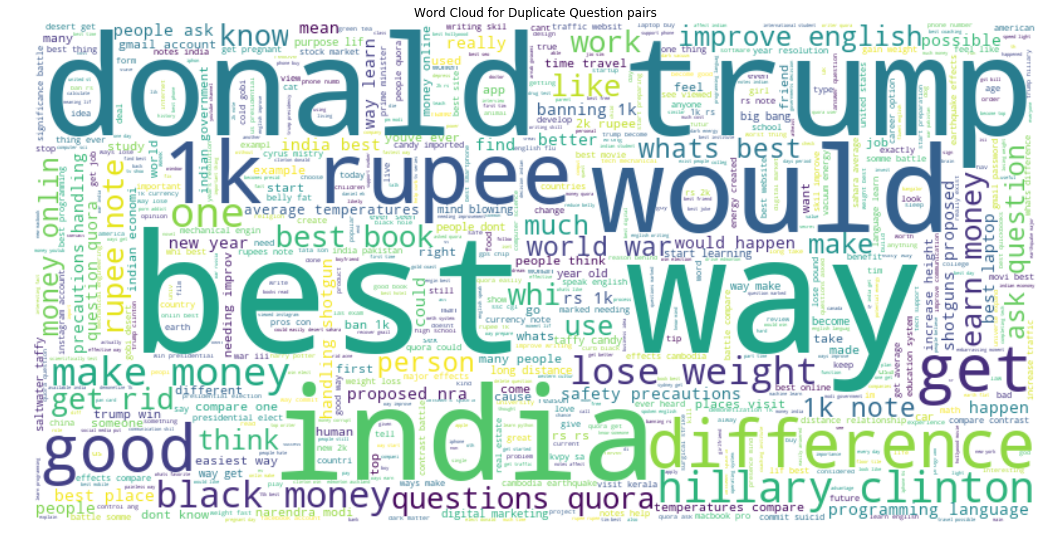

In [15]:
plt.figure(figsize=(18,10))
wc = WordCloud(width=800, height=400,background_color="white", max_words=len(dup_text), stopwords=STOP_WORDS)
wc.generate(dup_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Duplicate Question pairs")
plt.show()

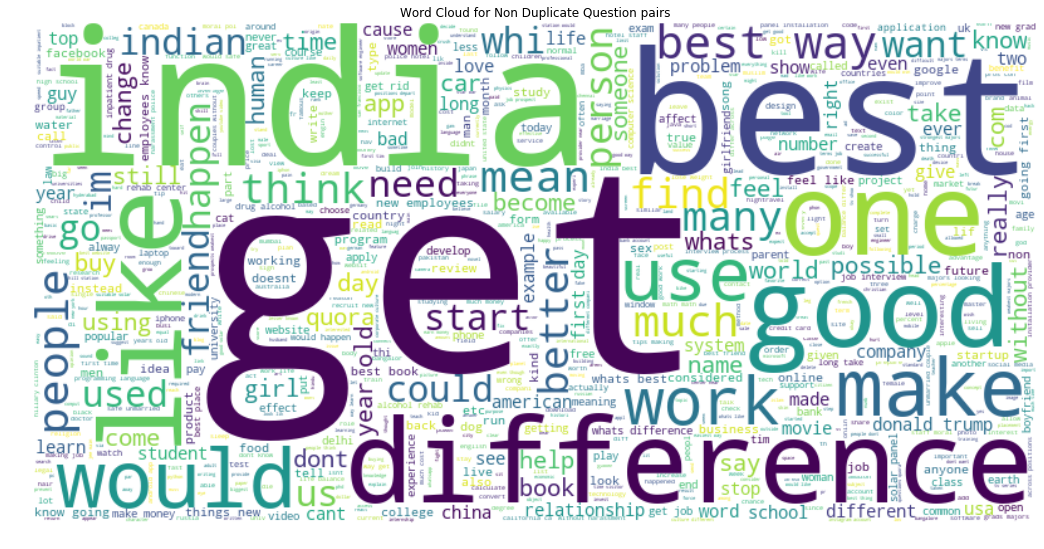

In [16]:
plt.figure(figsize=(18,10))
wc = WordCloud(width=800, height=400,background_color="white", max_words=len(nondup_text), stopwords=STOP_WORDS)
wc.generate(nondup_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Non Duplicate Question pairs")
plt.show()

## Modeling:

## Split the data randomly into Train, CV & Test (64:16:20)

In [19]:
y_dup = df['is_duplicate'].values
df = df.drop(['is_duplicate'], axis=1)
print(y_dup.shape)

(150000,)


In [20]:
df.head(1)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,30071,30072,how do i prepare for a firmware or embedded en...,in companies like google facebook amazon et...,1,1,147,129,26,22,...,0.192307,1.0,0.0,4.0,24.0,46,47,30,31,0.078125


**Since we are going to use simple CV for Linear SVM & Logistic Regression, let's split the data into Train, CV & Test**

In [23]:
X_1, df_test, y_1, y_test = train_test_split(df, y_dup, stratify=y_dup, test_size=0.2)
df_train, df_cv, y_train, y_cv = train_test_split(X_1, y_1, stratify=y_1, test_size=0.2)
print("Number of data points in train data :",df_train.shape)
print("Number of data points in CV data :",df_cv.shape)
print("Number of data points in test data :",df_test.shape)

Number of data points in train data : (96000, 30)
Number of data points in CV data : (24000, 30)
Number of data points in test data : (30000, 30)


<h2> Train TF-IDF Model </h2>

In [24]:
questions = list(df_train['question1']) + list(df_train['question2'])

In [25]:
STOP_WORDS = stopwords.words("english")
tfidf_model = TfidfVectorizer(ngram_range=(1,1), stop_words = STOP_WORDS )
tfidf_model.fit(questions)
train_q1_tfidf = tfidf_model.transform(df_train['question1'])
train_q2_tfidf = tfidf_model.transform(df_train['question2'])
cv_q1_tfidf = tfidf_model.transform(df_cv['question1'])
cv_q2_tfidf = tfidf_model.transform(df_cv['question2'])
test_q1_tfidf = tfidf_model.transform(df_test['question1'])
test_q2_tfidf = tfidf_model.transform(df_test['question2'])

In [26]:
test_q2_tfidf.shape

(30000, 48275)

In [27]:
df_train = df_train.drop(['question1','question2'], axis=1)
df_cv = df_cv.drop(['question1','question2'], axis=1)
df_test = df_test.drop(['question1','question2'], axis=1)

In [28]:
print("Number of data points in train data :",df_train.shape)
print("Number of data points in CV data :",df_cv.shape)
print("Number of data points in test data :",df_test.shape)

Number of data points in train data : (96000, 28)
Number of data points in CV data : (24000, 28)
Number of data points in test data : (30000, 28)


In [29]:
X_train = sparse.hstack((df_train.values.astype(float), train_q1_tfidf, train_q2_tfidf))
X_cv = sparse.hstack((df_cv.values.astype(float), cv_q1_tfidf, cv_q2_tfidf))
X_test = sparse.hstack((df_test.values.astype(float), test_q1_tfidf, test_q2_tfidf))

In [30]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in CV data :",X_cv.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (96000, 96578)
Number of data points in CV data : (24000, 96578)
Number of data points in test data : (30000, 96578)


In [31]:
print("Number of Duplicate(1) & Non-Duplicate(0) questions in Train : "+str(Counter(y_train)))
print("Number of Duplicate(1) & Non-Duplicate(0) questions in CV : "+str(Counter(y_cv)))
print("Number of Duplicate(1) & Non-Duplicate(0) questions in Test : "+str(Counter(y_test)))

Number of Duplicate(1) & Non-Duplicate(0) questions in Train : Counter({0: 60408, 1: 35592})
Number of Duplicate(1) & Non-Duplicate(0) questions in CV : Counter({0: 15102, 1: 8898})
Number of Duplicate(1) & Non-Duplicate(0) questions in Test : Counter({0: 18878, 1: 11122})


In [32]:
save_pickle('X_train.pkl',X_train)
save_pickle('X_cv.pkl',X_cv)
save_pickle('X_test.pkl',X_test)
save_pickle('y_train.pkl',y_train)
save_pickle('y_cv.pkl',y_cv)
save_pickle('y_test.pkl',y_test)

In [6]:
X_train = load_pickle('X_train.pkl')
X_cv = load_pickle('X_cv.pkl')
X_test = load_pickle('X_test.pkl')
y_train = load_pickle('y_train.pkl')
y_cv = load_pickle('y_cv.pkl')
y_test = load_pickle('y_test.pkl')

## Building a random model (Finding worst-case log-loss)

Log loss on CV Data using Random Model 0.8854414521066535
Log loss on Test Data using Random Model 0.8850605755079717


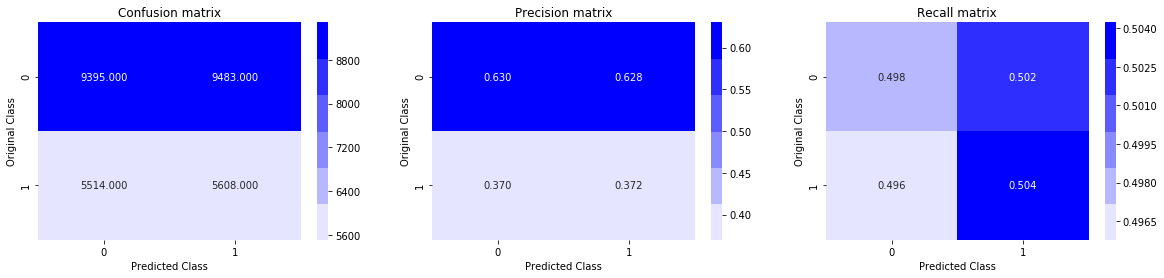


TPR: 0.504, TNR: 0.498, FPR: 0.502, FNR: 0.496



In [82]:
test_len = len(y_cv)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on CV Data using Random Model",log_loss(y_cv, predicted_y, eps=1e-15))

test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

**Obervation:** We have 0.88 as log loss for Random model. Hence anything less than that means the model is doing reasonably better than worse model.

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6593536372053314
For values of alpha =  0.0001 The log loss is: 0.6593536372053314
For values of alpha =  0.001 The log loss is: 0.6593536372053314
For values of alpha =  0.01 The log loss is: 0.6158879109161038
For values of alpha =  0.1 The log loss is: 0.6260319673944063
For values of alpha =  1 The log loss is: 0.6025342060960442
For values of alpha =  10 The log loss is: 0.6139055307409106
For values of alpha =  100 The log loss is: 0.6432903471455168
For values of alpha =  1000 The log loss is: 0.6097891448204297


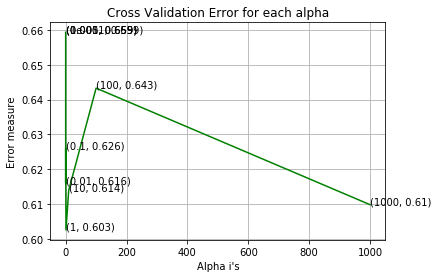

Time taken to run this cell : 0:08:37.719867


In [34]:
start = datetime.now()

alpha = [10 ** x for x in range(-5, 4)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', tol = 0.0001, max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

For values of best alpha = 1  The train log loss is: 0.6048752862199024
For values of best alpha = 1  The CV log loss is: 0.6025342060960442
For values of best alpha =   The test log loss is: 0.6027165724453557
Total number of Test data points : 30000


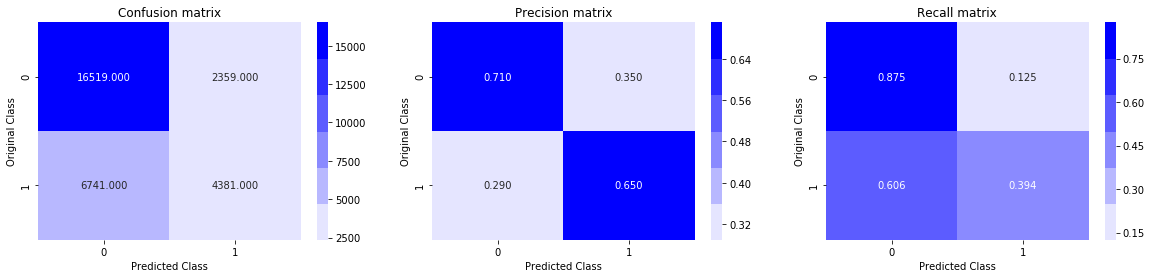


TPR: 0.394, TNR: 0.875, FPR: 0.125, FNR: 0.606

Time taken to run this cell : 0:00:49.731129


In [75]:
start = datetime.now()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', tol = 0.0001, max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_error_array[best_alpha])
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

**Observation:**

- Log loss is 0.6 which is better than Random model.
- Train, CV & Test log loss all are nearly same. Hence we are not fitting to Train data.
- Precision seems to be okay with 0.710 & 0.650 for Non-duplicate(0) and Duplicate(1) questions.
- However from Recall matrix and TPR we can see that classification on duplicate questions(1) is very low at 0.394. We need to improve it. TNR is good at 0.875.
- Let's see if we can improve this model.

***We know that our data set is neither balanced nor completely imbalanced. We have around 60% Non-duplicate(0) and 40% Duplicate(1) questions. Let's see if class_weight = 'balanced' will have any impact.***

For values of alpha =  1e-05 The log loss is: 0.6593536372053314
For values of alpha =  0.0001 The log loss is: 0.6593536372053314
For values of alpha =  0.001 The log loss is: 0.6593536372053314
For values of alpha =  0.01 The log loss is: 0.5883842595440879
For values of alpha =  0.1 The log loss is: 0.5977842170860029
For values of alpha =  1 The log loss is: 0.6028233726986044
For values of alpha =  10 The log loss is: 0.617019915523098
For values of alpha =  100 The log loss is: 0.6206749571444822
For values of alpha =  1000 The log loss is: 0.6076395262834392


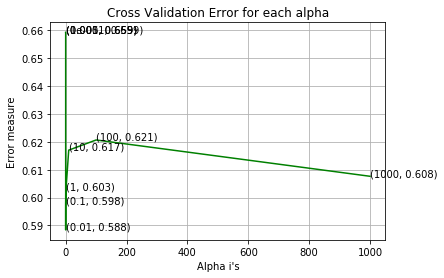

Time taken to run this cell : 0:07:15.170402


In [10]:
start = datetime.now()

alpha = [10 ** x for x in range(-5, 4)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', tol = 0.0001, max_iter=1000, \
                        class_weight ='balanced', random_state=42, n_jobs = 2)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

For values of best alpha =  0.01 The train log loss is: 0.5910405546713527
For values of best alpha =  0.01 The CV log loss is: 0.5883842595440879
For values of best alpha =  0.01 The test log loss is: 0.5886252733624854
Total number of Test data points : 30000


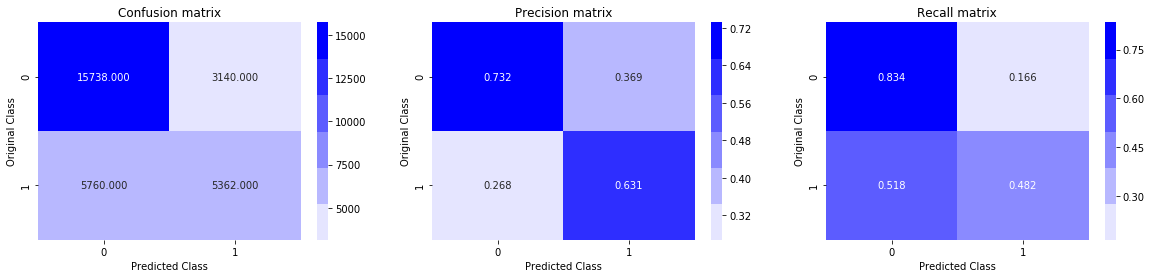


TPR: 0.482, TNR: 0.834, FPR: 0.166, FNR: 0.518

Time taken to run this cell : 0:00:51.513817


In [11]:
start = datetime.now()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', tol = 0.0001, \
                    max_iter=1000, class_weight ='balanced', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_error_array[best_alpha])
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

print("Time taken to run this cell :", datetime.now() - start)

**Observation:**

- Using class_weight = 'balanced' improved log loss to 0.59 for Train and 0.58 to CV & Test.
- Also TPR increased to 0.482 and TNR also good at 0.834. 
- But still TPR of 0.482 is very low meaning we are classifying more than half of Duplicate questions wrongly as Non-Duplicate. We need to improve it.
- So let's try other models.

## Linear SVM with hyperparameter tuning

For values of alpha =  0.0001 The log loss is: 0.6593536372053314
For values of alpha =  0.001 The log loss is: 0.6593536372053314
For values of alpha =  0.01 The log loss is: 0.6593536372053314
For values of alpha =  0.1 The log loss is: 0.6400158252539713
For values of alpha =  1 The log loss is: 0.6186663582721094
For values of alpha =  10 The log loss is: 0.6570453437905707
For values of alpha =  100 The log loss is: 0.6213686865076492


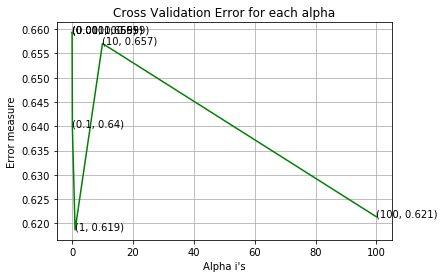

Time taken to run this cell : 0:00:10.254205


In [59]:
start = datetime.now()

alpha = [10 ** x for x in range(-4, 3)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

For values of best alpha =  1 The train log loss is: 0.6191728581918431
For values of best alpha =  1 The CV log loss is: 0.6186663582721094
For values of best alpha =  1 The test log loss is: 0.616494624932815
Total number of Test data points : 30000


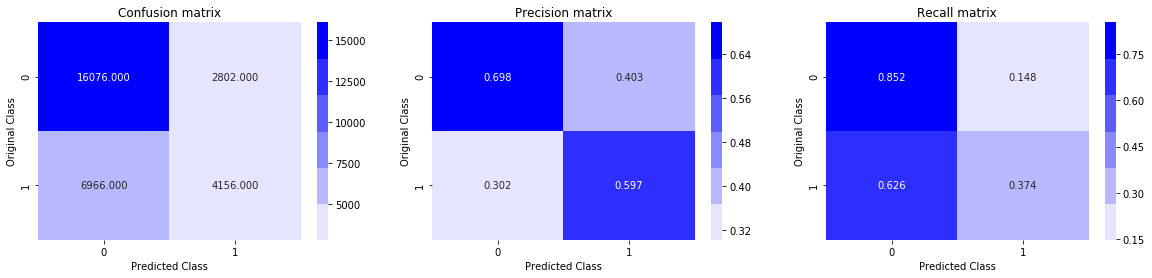


TPR: 0.374, TNR: 0.852, FPR: 0.148, FNR: 0.626



In [61]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_error_array[best_alpha])
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Observation:**

- Log loss is 0.61 which is better than Random model but slightly more than previous model of Logistic Regression.
- Train, CV & Test log loss all are nearly same. Hence we are not fitting to Train data.
- Precision has dropped with 0.698 & 0.597 for Non-duplicate(0) and Duplicate(1) questions.
- However from Recall matrix and TPR we can see that classification on duplicate questions(1) is very low at 0.374. We need to improve it. TNR is good at 0.852.
- Linear SVM, didn't do a good job. Infact it's performance is a bit lower than Logistic Regression. 
- Let's see if we can improve this model.

**class_weight = balanced**

For values of alpha =  0.0001 The log loss is: 0.6593536372053314
For values of alpha =  0.001 The log loss is: 0.6099582618364758
For values of alpha =  0.01 The log loss is: 0.6068216117777019
For values of alpha =  0.1 The log loss is: 0.6112300081957279
For values of alpha =  1 The log loss is: 0.6053237503637287
For values of alpha =  10 The log loss is: 0.6044912573910187
For values of alpha =  100 The log loss is: 0.612771648908135


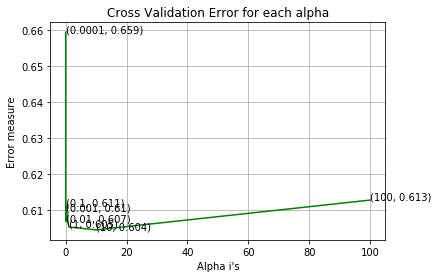

Time taken to run this cell : 0:04:48.003358


In [12]:
start = datetime.now()

alpha = [10 ** x for x in range(-4, 3)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', tol = 0.0001, \
                    max_iter=1000, class_weight = 'balanced', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

print("Time taken to run this cell :", datetime.now() - start)

For values of best alpha =  10 The train log loss is: 0.6201484810754451
For values of best alpha =  10 The CV log loss is: 0.6044912573910187
For values of best alpha =  10 The test log loss is: 0.6191896406029245
Total number of Test data points : 30000


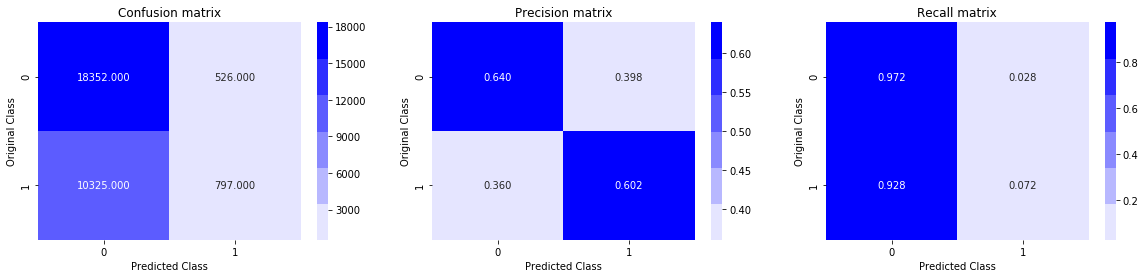


TPR: 0.072, TNR: 0.972, FPR: 0.028, FNR: 0.928



In [13]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge',tol = 0.0001, \
                    max_iter=1000, class_weight = 'balanced', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",log_error_array[best_alpha])
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of Test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Observation:**

- Using class_weight as balanced worsened the Linear SVM Model!
- So let's go for a more complex model like XGBoost.

## XGBoost using RandomizedSearchCV

***Since we are going to use RandomizedSearchCV, we don't need a separate CV data. So either we have to retrain our model by re-splitting to Train & Test or we can ignore the CV data and proceed which means we will be working on lesser number of points. But since we have sufficiently large amount of data in Train & test and to maintain uniformity of same Train & Test data points we shall ignore CV so that the trained model results can be comparaed with other models for same data.***

We have below set of options as hyper paramaters. Let's try out different combinations to arrive at optimal model.

In [ ]:
#Hyper params that can be used:
'''
params = {  
    "n_estimators": stats.randint(35, 100),
    "learning_rate": stats.uniform(0.05, 0.4),
    'reg_alpha': stats.expon(0, 50),
    "reg_lambda": stats.expon(0, 50),
    "max_depth": stats.randint(1, 10),
    "subsample": stats.beta(10, 1),
    "min_child_weight": stats.expon(0, 50),
    "colsample_bytree":stats.beta(10, 1)
}
'''

***First let's try with max_depth and learning_rate***

In [43]:
params = {  
    "max_depth": stats.randint(1, 10),
    "learning_rate": stats.uniform(0.05, 0.4)
}

In [44]:
start = datetime.now()

clf = XGBClassifier(n_jobs = 3)
random_search =RandomizedSearchCV(clf,params,scoring='neg_log_loss', verbose=1, cv=3)
random_search.fit(X_train,y_train)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.4min finished


Time taken to run this cell : 0:24:54.425862


In [45]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2844306597417618,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=3, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Results for Best params :  {'learning_rate': 0.2844306597417618, 'max_depth': 9}
The train log loss is: 0.24736796291830512
The CV log loss is: 0.3267224823189915
The test log loss is: 0.3265303662570454
Total number of Test data points : 30000


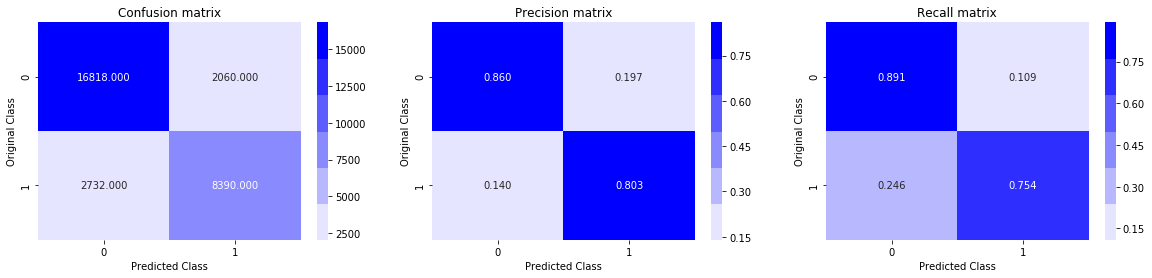


TPR: 0.754, TNR: 0.891, FPR: 0.109, FNR: 0.246



In [70]:
print("Results for Best params : ",random_search.best_params_)
predict_y = random_search.best_estimator_.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("The CV log loss is:",(-1*random_search.best_score_ ))
predict_y = random_search.best_estimator_.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("Total number of Test data points :", len(predicted_y))
predicted_y = random_search.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, predicted_y)

In [47]:
joblib.dump(random_search,'xgboostmodel1.pkl')

['xgboostmodel1.pkl']

**Observation:**

- CV and Test Log loss has reduced to 0.32 which is lot better than previous model.
- Precision and Recall values are also high and good. 
- Unlike previous models we have got good TPR of 0.754.
- But Train log loss of 0.24 and Test of 0.32 suggests that we might be overfitting our model to Train data. Same can be concluded from slightly higher TNR of 0.891.
- Hence let's try few other hyper paramaters and see whether we can reduce the difference between Train & Test log loss.

***Adding n_estimators as hyperparamater***

In [49]:
params = {  
    "learning_rate": stats.uniform(0.05, 0.4),
    "max_depth": stats.randint(1, 10),
    "n_estimators": stats.randint(35, 100)
}

In [50]:
start = datetime.now()

clf = XGBClassifier(n_jobs = 3)
random_search =RandomizedSearchCV(clf,params,scoring='neg_log_loss', verbose=1, cv=3)
random_search.fit(X_train,y_train)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.5min finished


Time taken to run this cell : 0:16:38.928893


In [51]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.34060652382818807,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=74, n_jobs=3, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Results for Best params :  {'learning_rate': 0.34060652382818807, 'max_depth': 9, 'n_estimators': 74}
The train log loss is: 0.25552492466901766
The CV log loss is: 0.32891357963207846
The test log loss is: 0.32855474692268377
Total number of Test data points : 30000


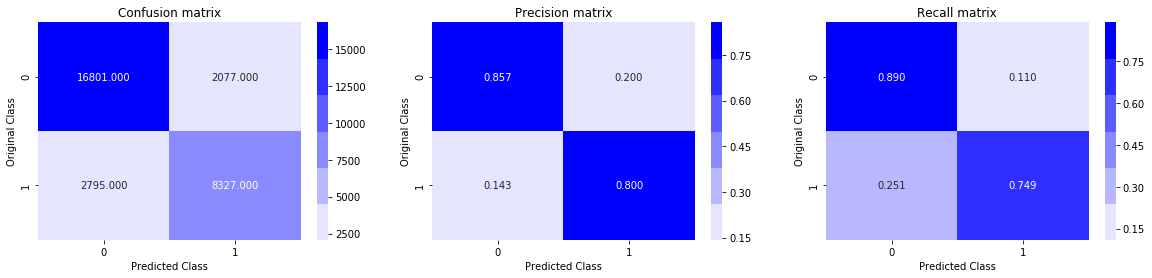


TPR: 0.749, TNR: 0.89, FPR: 0.11, FNR: 0.251



In [72]:
print("Results for Best params : ",random_search.best_params_)
predict_y = random_search.best_estimator_.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("The CV log loss is:",(-1*random_search.best_score_ ))
predict_y = random_search.best_estimator_.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("Total number of Test data points :", len(predicted_y))
predicted_y = random_search.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, predicted_y)

In [53]:
joblib.dump(random_search,'xgboostmodel2.pkl')

['xgboostmodel2.pkl']

**Observation:**

- Difference between Train & Test log loss had reduced but still there is a considerable amount of improvement required.
- Precision & Recall more or less look the same.

***Let's add regularization. Also since max_depth obtained was 9 in previous models. Let's fix that***

In [54]:
params = {  
    "n_estimators": stats.randint(35, 100),
    "learning_rate": stats.uniform(0.05, 0.4),
    'reg_alpha': stats.expon(0, 50),
    "reg_lambda": stats.expon(0, 50)
}

In [55]:
start = datetime.now()

clf = XGBClassifier(max_depth=9, n_jobs = 3)
random_search =RandomizedSearchCV(clf,params,scoring='neg_log_loss', verbose=1, cv=3)
random_search.fit(X_train,y_train)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 25.8min finished


Time taken to run this cell : 0:26:34.910812


In [56]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.33021250251405176,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=51, n_jobs=3, nthread=None,
       objective='binary:logistic', random_state=0,
       reg_alpha=3.8203003447566184, reg_lambda=18.47441112631638,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

Results for Best params : max_depth=9 &  {'learning_rate': 0.33021250251405176, 'n_estimators': 51, 'reg_alpha': 3.8203003447566184, 'reg_lambda': 18.47441112631638}
The train log loss is: 0.2889291081574841
The CV log loss is: 0.32726534900992527
The test log loss is: 0.3298658258596164
Total number of Test data points : 30000


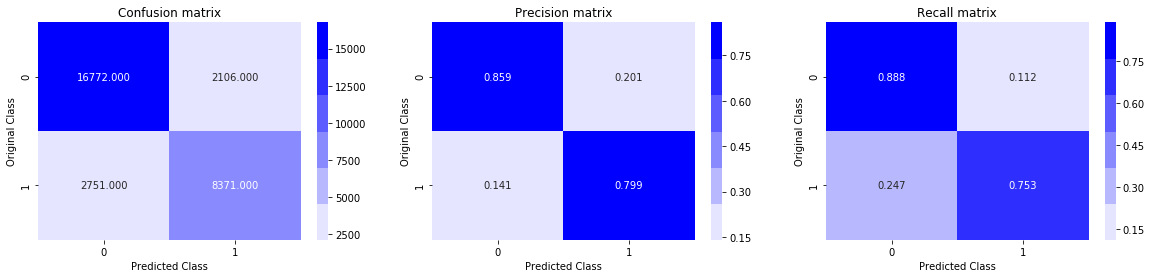


TPR: 0.753, TNR: 0.888, FPR: 0.112, FNR: 0.247



In [74]:
print("Results for Best params : max_depth=9 & ",random_search.best_params_)
predict_y = random_search.best_estimator_.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("The CV log loss is:",(-1*random_search.best_score_ ))
predict_y = random_search.best_estimator_.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("Total number of Test data points :", len(predicted_y))
predicted_y = random_search.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, predicted_y)

In [58]:
joblib.dump(random_search,'xgboostmodel3.pkl')

['xgboostmodel3.pkl']

**Obervation:**

- We have got Train log loss of 0.28 and CV & Test log loss of 0.32. Difference between Train & Test Log loss has reduced. But still there is some difference which suggests that we might be slightly overfitting the model to Train data.
- TPR has improved slightly.
- Let's try another model with all hyper paramaters and see if it performs better.

***With all hyper paramaters listed earlier***

In [62]:
params = {  
    "n_estimators": stats.randint(35, 100),
    "learning_rate": stats.uniform(0.05, 0.4),
    'reg_alpha': stats.expon(0, 50),
    "reg_lambda": stats.expon(0, 50),
    "max_depth": stats.randint(1, 10),
    "subsample": stats.beta(10, 1),
    "min_child_weight": stats.expon(0, 50),
    "colsample_bytree":stats.beta(10, 1)
}

In [63]:
start = datetime.now()

clf = XGBClassifier(n_jobs = 3)
random_search =RandomizedSearchCV(clf,params,n_iter=20, scoring='neg_log_loss', verbose=1, cv=3)
random_search.fit(X_train,y_train)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.6min finished


Time taken to run this cell : 0:21:28.474945


In [64]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.754548199531717, gamma=0,
       learning_rate=0.17387903946213074, max_delta_step=0, max_depth=9,
       min_child_weight=22.54696507906736, missing=None, n_estimators=86,
       n_jobs=3, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=3.1431627763024257, reg_lambda=25.355885563928947,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9949465155656035)

Results for Best params :  {'colsample_bytree': 0.754548199531717, 'learning_rate': 0.17387903946213074, 'max_depth': 9, 'min_child_weight': 22.54696507906736, 'n_estimators': 86, 'reg_alpha': 3.1431627763024257, 'reg_lambda': 25.355885563928947, 'subsample': 0.9949465155656035}
The train log loss is: 0.30586854674034325
The CV log loss is: 0.3301315831575463
The test log loss is: 0.33166850671755094
Total number of Test data points : 30000


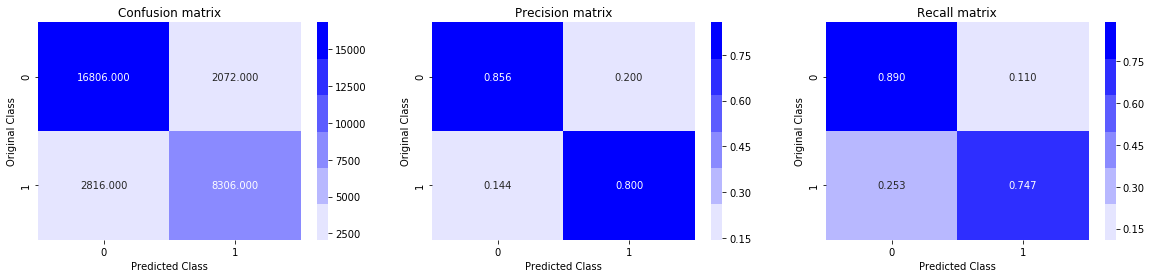


TPR: 0.747, TNR: 0.89, FPR: 0.11, FNR: 0.253



In [67]:
print("Results for Best params : ",random_search.best_params_)
predict_y = random_search.best_estimator_.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("The CV log loss is:",(-1*random_search.best_score_ ))
predict_y = random_search.best_estimator_.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("Total number of Test data points :", len(predicted_y))
predicted_y = random_search.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, predicted_y)

In [68]:
joblib.dump(random_search,'xgboostmodel4.pkl')

['xgboostmodel4.pkl']

**Observation:**

- With Train log loss of 0.3 and CV & Test log loss of 0.33 we have a good model compared to previous models.
- Precision and recall matrix also looks good with high values along diagonal elements.
- Only one concern would be high value of 0.89 to TNR and TPR being slightly lower than that at 0.747.
- One reason for this might be because we had Non duplicate(0) as 60% of our data and Duplicate(1) at 40%. Even though it's not completely imbalanaced, it's not balanced either.
- So let's try setting scale for pos_weight and see.

***With scale_pos_weight set***

In [76]:
#scale_pos_weight for GBDT
pos_weight  = float(np.sum(y_train == 0)) / np.sum(y_train==1)
pos_weight

1.6972353337828725

In [77]:
params = {  
    "n_estimators": stats.randint(35, 100),
    "learning_rate": stats.uniform(0.05, 0.4),
    'reg_alpha': stats.expon(0, 50),
    "reg_lambda": stats.expon(0, 50),
    "max_depth": stats.randint(1, 10),
    "subsample": stats.beta(10, 1),
    "min_child_weight": stats.expon(0, 50),
    "colsample_bytree":stats.beta(10, 1)
}

In [78]:
start = datetime.now()

clf = XGBClassifier(scale_pos_weight = pos_weight,n_jobs = 3)
random_search =RandomizedSearchCV(clf,params,n_iter=20, scoring='neg_log_loss', verbose=1, cv=3)
random_search.fit(X_train,y_train)

print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 30.1min finished


Time taken to run this cell : 0:30:50.801286


In [79]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9973313657878562, gamma=0,
       learning_rate=0.41732818115953524, max_delta_step=0, max_depth=5,
       min_child_weight=5.998027367390265, missing=None, n_estimators=95,
       n_jobs=3, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=27.88439535978324, reg_lambda=8.032750843268731,
       scale_pos_weight=1.6972353337828725, seed=None, silent=True,
       subsample=0.9084177381140088)

Results for Best params :  {'colsample_bytree': 0.9973313657878562, 'learning_rate': 0.41732818115953524, 'max_depth': 5, 'min_child_weight': 5.998027367390265, 'n_estimators': 95, 'reg_alpha': 27.88439535978324, 'reg_lambda': 8.032750843268731, 'subsample': 0.9084177381140088}
The train log loss is: 0.31983543307766255
The CV log loss is: 0.34311144584030173
The test log loss is: 0.3464013666356099
Total number of Test data points : 30000


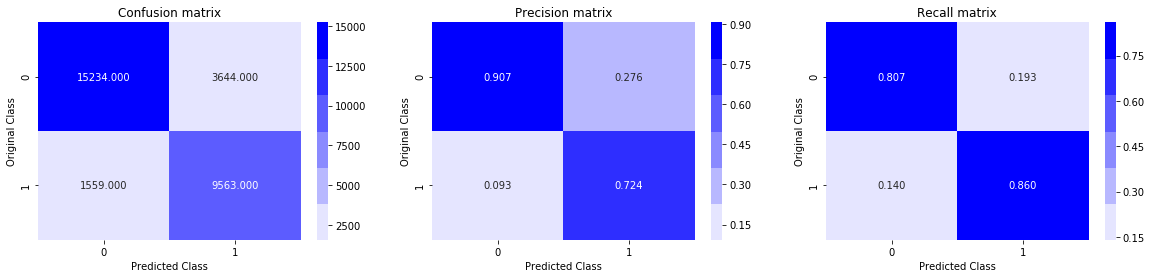


TPR: 0.86, TNR: 0.807, FPR: 0.193, FNR: 0.14



In [80]:
print("Results for Best params : ",random_search.best_params_)
predict_y = random_search.best_estimator_.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("The CV log loss is:",(-1*random_search.best_score_ ))
predict_y = random_search.best_estimator_.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.best_estimator_.classes_, eps=1e-15))
print("Total number of Test data points :", len(predicted_y))
predicted_y = random_search.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, predicted_y)

In [81]:
joblib.dump(random_search,'xgboostmodel5.pkl')

['xgboostmodel5.pkl']

**Observation:**

- With Train log loss at 0.31 and CV & Test log loss at 0.34 we have our best model.
- From Precision & Recall matrix and also TPR of 0.86 & TNR of 0.807 we can say that balancing weights helped in model performing better on Duplicate(1) questions which used to be low in earlier models.

## Summary of best results for each model: 

In [16]:
x = PrettyTable()

x.field_names = ["Method", "Log Loss", "TPR", "TNR"]

x.add_row(["Random Model","0.88","0.504", "0.498"])
x.add_row(["Logistic Regression","0.58", "0.482", "0.834"])
x.add_row(["Linear SVM","0.61","0.374", "0.852"])
x.add_row(["XGBoost","0.34","0.86","0.807"])



print("Summary of Optimal Results")
print(x)

print("\n Best Model")
x = PrettyTable()

x.field_names = ["Method", "Log Loss", "TPR", "TNR"]
x.add_row(["XGBoost","0.34","0.86","0.807"])
print(x)

Summary of Optimal Results
+---------------------+----------+-------+-------+
|        Method       | Log Loss |  TPR  |  TNR  |
+---------------------+----------+-------+-------+
|     Random Model    |   0.88   | 0.504 | 0.498 |
| Logistic Regression |   0.58   | 0.482 | 0.834 |
|      Linear SVM     |   0.61   | 0.374 | 0.852 |
|       XGBoost       |   0.34   |  0.86 | 0.807 |
+---------------------+----------+-------+-------+

 Best Model
+---------+----------+------+-------+
|  Method | Log Loss | TPR  |  TNR  |
+---------+----------+------+-------+
| XGBoost |   0.34   | 0.86 | 0.807 |
+---------+----------+------+-------+


# Summary:

1. Even though dimensions were high Logistic Regression and Linear SVM didn't perform as well as expected.
2. XGBoost worked very well when all the hyper paramaters were used.
3. XGBoost performance further improved when classes were balanced.
4. Best results obtained for each of the models are as seen in the above table.
5. Among all the models XGBoost performed the best.